In [628]:
'''The purpose of this code is to use models to determine whether a character 
in Game of Thrones survives or not. 
First: The data will be imported and viewed.
Second: The missing data will be imputed.
Third: Names separated and run through gender guesser
Fourth: Making of the models
Fifth: Ranking of the models
Sixth: Declaration of best model'''

# importing libraries
import pandas            as pd                       # data science essentials
import matplotlib.pyplot as plt                      # data visualization
import seaborn           as sns                      # enhanced data viz
import numpy             as np
from sklearn.model_selection import train_test_split # train-test split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression  # logistic regression
import statsmodels.formula.api as smf                # logistic regression
from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.metrics import roc_auc_score            # auc score
from sklearn.neighbors import KNeighborsClassifier   # KNN for classification
from sklearn.neighbors import KNeighborsRegressor    # KNN for regression
from sklearn.preprocessing import StandardScaler     # standard scaler
from sklearn.tree import DecisionTreeClassifier      # classification trees
from sklearn.tree import plot_tree                   # tree plots
import gender_guesser.detector as gender             # guess gender based on (given) name
from sklearn.model_selection import RandomizedSearchCV     # hyperparameter tuning
from sklearn.metrics import make_scorer              # customizable scorer
from sklearn.ensemble import RandomForestClassifier     # random forest
from sklearn.ensemble import GradientBoostingClassifier # gbm


# loading data
GOTC = "./__storage/GOT_character_predictions.xlsx"

GOTC = pd.read_excel(    io = GOTC, 
                     header = 0,
                 sheet_name = 0)

# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)


# displaying the head of the dataset
GOTC.head(n = 5)

,S.No,name,title,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive
0,1,Viserys II Targaryen,NaN,NaN,NaN,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,NaN,NaN,0,0,0,0,0,1.0,0.0,0.0,NaN,0,0,NaN,11,0.605351,0
1,2,Walder Frey,Lord of the Crossing,Rivermen,208.0,NaN,NaN,NaN,House Frey,Perra Royce,1,1,1,1,1,NaN,NaN,NaN,1.0,1,1,97.0,1,0.896321,1
2,3,Addison Hill,Ser,NaN,NaN,NaN,NaN,NaN,House Swyft,NaN,0,0,0,1,0,NaN,NaN,NaN,NaN,0,1,NaN,0,0.267559,1
3,4,Aemma Arryn,Queen,NaN,82.0,NaN,NaN,NaN,House Arryn,Viserys I Targaryen,0,0,0,0,0,NaN,NaN,NaN,0.0,1,1,23.0,0,0.183946,0
4,5,Sylva Santagar,Greenstone,Dornish,276.0,NaN,NaN,NaN,House Santagar,Eldon Estermont,0,0,0,1,0,NaN,NaN,NaN,1.0,1,1,29.0,0,0.043478,1


In [629]:
GOTC.isnull().sum()

S.No                             0
name                             0
title                         1008
culture                       1269
dateOfBirth                   1513
mother                        1925
father                        1920
heir                          1923
house                          427
spouse                        1670
book1_A_Game_Of_Thrones          0
book2_A_Clash_Of_Kings           0
book3_A_Storm_Of_Swords          0
book4_A_Feast_For_Crows          0
book5_A_Dance_with_Dragons       0
isAliveMother                 1925
isAliveFather                 1920
isAliveHeir                   1923
isAliveSpouse                 1670
isMarried                        0
isNoble                          0
age                           1513
numDeadRelations                 0
popularity                       0
isAlive                          0
dtype: int64

In [630]:
GOTC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   S.No                        1946 non-null   int64  
 1   name                        1946 non-null   object 
 2   title                       938 non-null    object 
 3   culture                     677 non-null    object 
 4   dateOfBirth                 433 non-null    float64
 5   mother                      21 non-null     object 
 6   father                      26 non-null     object 
 7   heir                        23 non-null     object 
 8   house                       1519 non-null   object 
 9   spouse                      276 non-null    object 
 10  book1_A_Game_Of_Thrones     1946 non-null   int64  
 11  book2_A_Clash_Of_Kings      1946 non-null   int64  
 12  book3_A_Storm_Of_Swords     1946 non-null   int64  
 13  book4_A_Feast_For_Crows     1946 

In [631]:
# sum the number of alive and dead characters and show skewness
def isAlive_Skew():
    num_alive = sum(GOTC['isAlive'] == 1)
    num_dead  = sum(GOTC['isAlive'] == 0)
    isAlive_skew = GOTC["isAlive"].skew().round(decimals = 4)
    print(f"""Number of alive characters: {num_alive}
Number of dead characters: {num_dead}
Total characters: {num_alive + num_dead}
Skewness: {isAlive_skew}""")

isAlive_Skew()

Number of alive characters: 1451
Number of dead characters: 495
Total characters: 1946
Skewness: -1.1289


In [632]:
# create new column that sums 'age' and 'dateOfBirth'
GOTC['dob_age'] = 0
for row, col in GOTC.iterrows():
    GOTC.loc[row,'dob_age'] = GOTC.loc[row,'age']+  GOTC.loc[row,'dateOfBirth']

In [633]:
# looping to detect features with missing values
for column in GOTC:
    # creating columns with 1s if missing and 0 if not
    if GOTC[column].isnull().astype(int).sum() > 0:
        GOTC['m_'+column] = GOTC[column].isnull().astype(int)
        
# summing the missing value flags to check the results of the loop above
GOTC[['m_title', 'm_culture','m_dateOfBirth','m_mother',
      'm_father','m_heir','m_house','m_spouse','m_isAliveMother',
      'm_isAliveFather','m_isAliveHeir','m_isAliveSpouse',
      'm_age', 'm_dob_age']].sum(axis = 0)

m_title            1008
m_culture          1269
m_dateOfBirth      1513
m_mother           1925
m_father           1920
m_heir             1923
m_house             427
m_spouse           1670
m_isAliveMother    1925
m_isAliveFather    1920
m_isAliveHeir      1923
m_isAliveSpouse    1670
m_age              1513
m_dob_age          1513
dtype: int64

In [634]:
# Impute the missing values, the unique values like title, culture, heir, etc
# will be replaced with "none". The binary values will be replaced with '0's 
# assuming they are dead. Lastly the age will be filled in with the median.
GOTC['title'].fillna(value = 'None', inplace = True)
GOTC['culture'].fillna(value = 'None', inplace = True)
GOTC['mother'].fillna(value = 'None', inplace = True)
GOTC['father'].fillna(value = 'None', inplace = True)
GOTC['heir'].fillna(value = 'None', inplace = True)
GOTC['house'].fillna(value = 'None', inplace = True)
GOTC['spouse'].fillna(value = 'None', inplace = True)

GOTC['isAliveMother'].fillna(value = '0', inplace = True)
GOTC['isAliveFather'].fillna(value = '0', inplace = True)
GOTC['isAliveHeir'].fillna(value = '0', inplace = True)
GOTC['isAliveSpouse'].fillna(value = '0', inplace = True)
GOTC['dateOfBirth'].fillna(value = '0', inplace = True)
GOTC['dob_age'].fillna(value = '0', inplace = True)

age_median = GOTC['age'].median()
GOTC['age'].fillna(value = age_median, inplace = True)

In [613]:
GOTC.isnull().sum()

S.No                          0
name                          0
title                         0
culture                       0
dateOfBirth                   0
mother                        0
father                        0
heir                          0
house                         0
spouse                        0
book1_A_Game_Of_Thrones       0
book2_A_Clash_Of_Kings        0
book3_A_Storm_Of_Swords       0
book4_A_Feast_For_Crows       0
book5_A_Dance_with_Dragons    0
isAliveMother                 0
isAliveFather                 0
isAliveHeir                   0
isAliveSpouse                 0
isMarried                     0
isNoble                       0
age                           0
numDeadRelations              0
popularity                    0
isAlive                       0
dob_age                       0
m_title                       0
m_culture                     0
m_dateOfBirth                 0
m_mother                      0
m_father                      0
m_heir  

In [591]:
%pip install gender_guesser

Note: you may need to restart the kernel to use updated packages.


In [592]:
# STEP 1: splitting names

# placeholder list
placeholder_lst = []

# looping over each names
for index, col in GOTC.iterrows():
    
    # splitting email domain at '(space) '
    split_name = GOTC.loc[index, 'name'].split(sep = ' ')
    
    # appending placeholder_lst with the results
    placeholder_lst.append(split_name)
    

# converting placeholder_lst into a DataFrame 
GOTC_names = pd.DataFrame(placeholder_lst)


# displaying the results
GOTC_names

,0,1,2,3,4,5
0,Viserys,II,Targaryen,None,None,None
1,Walder,Frey,None,None,None,None
2,Addison,Hill,None,None,None,None
3,Aemma,Arryn,None,None,None,None
4,Sylva,Santagar,None,None,None,None
...,...,...,...,...,...,...
1941,Luwin,None,None,None,None,None
1942,Reek,None,None,None,None,None
1943,Symeon,Star-Eyes,None,None,None,None
1944,Coldhands,None,None,None,None,None


In [593]:
GOTC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   S.No                        1946 non-null   int64  
 1   name                        1946 non-null   object 
 2   title                       1946 non-null   object 
 3   culture                     1946 non-null   object 
 4   dateOfBirth                 1946 non-null   object 
 5   mother                      1946 non-null   object 
 6   father                      1946 non-null   object 
 7   heir                        1946 non-null   object 
 8   house                       1946 non-null   object 
 9   spouse                      1946 non-null   object 
 10  book1_A_Game_Of_Thrones     1946 non-null   int64  
 11  book2_A_Clash_Of_Kings      1946 non-null   int64  
 12  book3_A_Storm_Of_Swords     1946 non-null   int64  
 13  book4_A_Feast_For_Crows     1946 

In [595]:
# guessing gender based on (given) name

# placeholder list
placeholder_lst = []


# looping to guess gender
for firstname in GOTC_names[0]:
    guess = gender.Detector().get_gender(firstname)
    print(guess)
    placeholder_lst.append(guess)


# converting list into a series
GOTC_names['gender_guess'] = pd.Series(placeholder_lst)


# checking results
GOTC_names.head(n = 5)

unknown
unknown
andy
unknown
female
unknown
unknown
unknown
male
male
mostly_male
mostly_male
mostly_male
mostly_male
mostly_male
mostly_male
unknown
male
unknown
unknown
male
male
female
unknown
unknown
female
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
mostly_female
unknown
unknown
unknown
unknown
unknown
female
unknown
unknown
male
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
male
unknown
unknown
unknown
unknown
unknown
unknown
female
unknown
unknown
unknown
male
male
andy
andy
unknown
andy
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
female
male
male
unknown
male
male
male
male
male
male
male
mostly_male
male
mostly_male
mostly_male
unknown
unknown
unknown
male
unknown
male
unknown
male
unknown
male
unknown
unknown
male
unknown
unknown
unknown
unknown
unknown
unknown
female
unknown
mostly_male
unknown
unknown
male


unknown
unknown
unknown
unknown
unknown
unknown
unknown
male
unknown
male
unknown
unknown
unknown
unknown
unknown
male
unknown
unknown
unknown
female
unknown
male
male
male
male
unknown
unknown
unknown
unknown
unknown
unknown
unknown
male
male
male
male
male
male
male
male
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
female
unknown
unknown
unknown
unknown
unknown
unknown
unknown
female
female
male
unknown
unknown
unknown
unknown
unknown
unknown
male
male
female
unknown
female
male
unknown
unknown
unknown
unknown
unknown
unknown
male
male
male
unknown
unknown
unknown
unknown
unknown
unknown
unknown
male
unknown
male
unknown
unknown
male
unknown
female
unknown
unknown
unknown
mostly_male
male
unknown
unknown
male
male
male
unknown
female
unknown
unknown
unknown
unknown
female
unknown
female
female
female
male
male
unknown
unknown
unknown
male
male
unknown
male
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
unknown
female
unknown

,0,1,2,3,4,5,gender_guess
0,Viserys,II,Targaryen,None,None,None,unknown
1,Walder,Frey,None,None,None,None,unknown
2,Addison,Hill,None,None,None,None,andy
3,Aemma,Arryn,None,None,None,None,unknown
4,Sylva,Santagar,None,None,None,None,female


In [635]:
gender_guess = GOTC_names['gender_guess']
GOTC = GOTC.join(gender_guess)

In [636]:
GOTC.head(n = 5)

,S.No,name,title,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive,dob_age,m_title,m_culture,m_dateOfBirth,m_mother,m_father,m_heir,m_house,m_spouse,m_isAliveMother,m_isAliveFather,m_isAliveHeir,m_isAliveSpouse,m_age,m_dob_age,gender_guess
0,1,Viserys II Targaryen,None,None,0,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,None,None,0,0,0,0,0,1.0,0.0,0.0,0,0,0,27.0,11,0.605351,0,0,1,1,1,0,0,0,1,1,0,0,0,1,1,1,unknown
1,2,Walder Frey,Lord of the Crossing,Rivermen,208.0,None,None,None,House Frey,Perra Royce,1,1,1,1,1,0,0,0,1.0,1,1,97.0,1,0.896321,1,305.0,0,0,0,1,1,1,0,0,1,1,1,0,0,0,unknown
2,3,Addison Hill,Ser,None,0,None,None,None,House Swyft,None,0,0,0,1,0,0,0,0,0,0,1,27.0,0,0.267559,1,0,0,1,1,1,1,1,0,1,1,1,1,1,1,1,andy
3,4,Aemma Arryn,Queen,None,82.0,None,None,None,House Arryn,Viserys I Targaryen,0,0,0,0,0,0,0,0,0.0,1,1,23.0,0,0.183946,0,105.0,0,1,0,1,1,1,0,0,1,1,1,0,0,0,unknown
4,5,Sylva Santagar,Greenstone,Dornish,276.0,None,None,None,House Santagar,Eldon Estermont,0,0,0,1,0,0,0,0,1.0,1,1,29.0,0,0.043478,1,305.0,0,0,0,1,1,1,0,0,1,1,1,0,0,0,female


In [637]:
#Create bins and dummies for gender and dob_age
for index, col in GOTC.iterrows():

    if GOTC.loc[index, "gender_guess"] == "unknown": 
        GOTC.loc[index, "gender"] = "unknown"
    elif GOTC.loc[index, "gender_guess"] == "andy": 
        GOTC.loc[index, "gender"] = "andy"
    elif GOTC.loc[index, "gender_guess"] == 'female' or 'mostly_female': 
        GOTC.loc[index, "gender"] = "female"
    elif GOTC.loc[index, "gender_guess"] == 'male' or 'mostly_male': 
        GOTC.loc[index, "gender"] = "male"        
    else:
        print('Gender Bin Error')
               
        
#Create dummies for gender
GOTC_dummy = pd.get_dummies(columns = ["gender"], data = GOTC)
GOTC = GOTC_dummy

GOTC.head(n = 10)

,S.No,name,title,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive,dob_age,m_title,m_culture,m_dateOfBirth,m_mother,m_father,m_heir,m_house,m_spouse,m_isAliveMother,m_isAliveFather,m_isAliveHeir,m_isAliveSpouse,m_age,m_dob_age,gender_guess,gender_andy,gender_female,gender_unknown
0,1,Viserys II Targaryen,None,None,0,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,None,None,0,0,0,0,0,1.0,0.0,0.0,0,0,0,27.0,11,0.605351,0,0,1,1,1,0,0,0,1,1,0,0,0,1,1,1,unknown,0,0,1
1,2,Walder Frey,Lord of the Crossing,Rivermen,208.0,None,None,None,House Frey,Perra Royce,1,1,1,1,1,0,0,0,1.0,1,1,97.0,1,0.896321,1,305.0,0,0,0,1,1,1,0,0,1,1,1,0,0,0,unknown,0,0,1
2,3,Addison Hill,Ser,None,0,None,None,None,House Swyft,None,0,0,0,1,0,0,0,0,0,0,1,27.0,0,0.267559,1,0,0,1,1,1,1,1,0,1,1,1,1,1,1,1,andy,1,0,0
3,4,Aemma Arryn,Queen,None,82.0,None,None,None,House Arryn,Viserys I Targaryen,0,0,0,0,0,0,0,0,0.0,1,1,23.0,0,0.183946,0,105.0,0,1,0,1,1,1,0,0,1,1,1,0,0,0,unknown,0,0,1
4,5,Sylva Santagar,Greenstone,Dornish,276.0,None,None,None,House Santagar,Eldon Estermont,0,0,0,1,0,0,0,0,1.0,1,1,29.0,0,0.043478,1,305.0,0,0,0,1,1,1,0,0,1,1,1,0,0,0,female,0,1,0
5,6,Tommen Baratheon,None,None,0,Cersei Lannister,Robert Baratheon,Myrcella Baratheon,None,None,0,0,0,0,0,1.0,1.0,1.0,0,0,0,27.0,5,1.000000,1,0,1,1,1,0,0,0,1,1,0,0,0,1,1,1,unknown,0,0,1
6,7,Valarr Targaryen,Hand of the King,Valyrian,183.0,None,None,None,House Targaryen,Kiera of Tyrosh,0,0,0,0,0,0,0,0,1.0,1,1,26.0,0,0.431438,0,209.0,0,0,0,1,1,1,0,0,1,1,1,0,0,0,unknown,0,0,1
7,8,Viserys I Targaryen,None,None,0,Alyssa Targaryen,Baelon Targaryen,Rhaenyra Targaryen,None,None,0,0,0,0,0,1.0,1.0,1.0,0,0,0,27.0,5,0.678930,0,0,1,1,1,0,0,0,1,1,0,0,0,1,1,1,unknown,0,0,1
8,9,Wilbert,Ser,None,0,None,None,None,None,None,0,0,1,0,0,0,0,0,0,0,1,27.0,0,0.006689,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,male,0,1,0
9,10,Wilbert Osgrey,Ser,None,0,None,None,None,House Osgrey,None,0,0,0,0,0,0,0,0,0,0,1,27.0,0,0.020067,1,0,0,1,1,1,1,1,0,1,1,1,1,1,1,1,male,0,1,0


In [638]:
# preparing explanatory variable data
GOTC_data  = GOTC.drop(['isAlive','gender_guess', 'age', 'dateOfBirth'], axis = 1)

# preparing response variables
GOTC_target = GOTC.loc[ : , 'isAlive' ]


# preparing training and testing sets (all letters are lowercase)
x_train, x_test, y_train, y_test = train_test_split(
            GOTC_data,
            GOTC_target,
            test_size    = 0.10,
            random_state = 219,
            stratify     = GOTC_target) # preserving balance

# merging training data for statsmodels
GOTC_train = pd.concat([x_train, y_train], axis = 1)


# checking the shapes of the datasets
print(f"""
Training Data
-------------
X-side: {x_train.shape}
y-side: {y_train.shape}


Testing Data
------------
X-side: {x_test.shape}
y-side: {y_test.shape}
""")


Training Data
-------------
X-side: (1751, 40)
y-side: (1751,)


Testing Data
------------
X-side: (195, 40)
y-side: (195,)



In [639]:
print(f"""

Response Variable Proportions (Training Set)
--------------------------------------------
{y_train.value_counts(normalize = True).round(decimals = 2)}



Response Variable Proportions (Testing Set)
--------------------------------------------
{y_test.value_counts(normalize = True).round(decimals = 2)}
""")




Response Variable Proportions (Training Set)
--------------------------------------------
1    0.75
0    0.25
Name: isAlive, dtype: float64



Response Variable Proportions (Testing Set)
--------------------------------------------
1    0.74
0    0.26
Name: isAlive, dtype: float64



In [640]:
# check correlation between all of the variables and 'isAlive'
GOTC_corr = GOTC.corr(method = 'pearson')
GOTC_corr['isAlive'].round(decimals = 3).sort_values(ascending = False)

isAlive                       1.000
book4_A_Feast_For_Crows       0.269
m_dateOfBirth                 0.150
m_dob_age                     0.150
m_age                         0.150
m_mother                      0.145
m_isAliveMother               0.145
m_isAliveFather               0.138
m_father                      0.138
m_isAliveHeir                 0.133
m_heir                        0.133
age                           0.055
m_spouse                      0.050
m_isAliveSpouse               0.050
m_title                       0.041
m_house                       0.039
m_culture                     0.037
book5_A_Dance_with_Dragons    0.033
gender_female                 0.027
gender_andy                   0.009
book3_A_Storm_Of_Swords       0.007
gender_unknown               -0.028
isNoble                      -0.042
isMarried                    -0.050
book2_A_Clash_Of_Kings       -0.067
S.No                         -0.129
book1_A_Game_Of_Thrones      -0.147
popularity                  

In [642]:
# Instantiating a logistic regression model object
logistic_small = smf.logit(formula   = "isAlive ~ book4_A_Feast_For_Crows",
                                        data = GOTC_train)


# FITTING the model object
results_logistic = logistic_small.fit()


# Checking the results 
results_logistic.summary2() #AIC BIC

Optimization terminated successfully.
         Current function value: 0.534562
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
====================================================================
Model:               Logit             Pseudo R-squared:  0.057     
Dependent Variable:  isAlive           AIC:               1876.0368 
Date:                2021-12-05 21:24  BIC:               1886.9727 
No. Observations:    1751              Log-Likelihood:    -936.02   
Df Model:            1                 LL-Null:           -992.53   
Df Residuals:        1749              LLR p-value:       2.1241e-26
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      6.0000                                         
--------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------
Intercept               0.4601   0.0765  6.0172 0.0000 0.3102 0.6100
book4_A_Feast_For_Crows 1.1895   0.1141 10.4212 0.0000 0.9658 1.4132
====================================================================

"""

In [643]:
# for loop to add a + to each column name
for val in GOTC_data:
    print(f" {val} + ")

 S.No + 
 name + 
 title + 
 culture + 
 mother + 
 father + 
 heir + 
 house + 
 spouse + 
 book1_A_Game_Of_Thrones + 
 book2_A_Clash_Of_Kings + 
 book3_A_Storm_Of_Swords + 
 book4_A_Feast_For_Crows + 
 book5_A_Dance_with_Dragons + 
 isAliveMother + 
 isAliveFather + 
 isAliveHeir + 
 isAliveSpouse + 
 isMarried + 
 isNoble + 
 numDeadRelations + 
 popularity + 
 dob_age + 
 m_title + 
 m_culture + 
 m_dateOfBirth + 
 m_mother + 
 m_father + 
 m_heir + 
 m_house + 
 m_spouse + 
 m_isAliveMother + 
 m_isAliveFather + 
 m_isAliveHeir + 
 m_isAliveSpouse + 
 m_age + 
 m_dob_age + 
 gender_andy + 
 gender_female + 
 gender_unknown + 


In [644]:
# instantiating a logistic regression model object
logistic_full = smf.logit(formula   = """isAlive ~ 
 book1_A_Game_Of_Thrones + 
 book2_A_Clash_Of_Kings + 
 book4_A_Feast_For_Crows +
 popularity +
 
 dob_age +
 m_house +
 m_mother
 """,
                           data      = GOTC_train)


# FITTING the model object
results_logistic = logistic_full.fit()


# checking the results SUMMARY
results_logistic.summary2() # summary2() has AIC and BIC

         Current function value: 0.367828
         Iterations: 35


/Users/noahdelisi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                    Results: Logit
=======================================================================================
Model:                     Logit                   Pseudo R-squared:        0.351      
Dependent Variable:        isAlive                 AIC:                     1414.1331  
Date:                      2021-12-05 21:24        BIC:                     1758.6134  
No. Observations:          1751                    Log-Likelihood:          -644.07    
Df Model:                  62                      LL-Null:                 -992.53    
Df Residuals:              1688                    LLR p-value:             3.4888e-108
Converged:                 0.0000                  Scale:                   1.0000     
No. Iterations:            35.0000                                                     
---------------------------------------------------------------------------------------
                         Coef.     Std.Err.      z    P>|z|      [0.025       0.975]   
---------------------------------------------------------------------------------------
Intercept               -22.6219   88628.7435 -0.0003 0.9998  -173731.7671  173686.5232
dob_age[T.43.0]          -1.5431  130961.3599 -0.0000 1.0000  -256681.0919  256678.0056
dob_age[T.44.0]          -0.8839  130961.2641 -0.0000 1.0000  -256680.2448  256678.4770
dob_age[T.47.0]          -1.2180  130961.3146 -0.0000 1.0000  -256680.6780  256678.2421
dob_age[T.82.0]          -1.2869  130961.3242 -0.0000 1.0000  -256680.7658  256678.1919
dob_age[T.105.0]         -1.8632  132332.7335 -0.0000 1.0000  -259369.2548  259365.5284
dob_age[T.114.0]         -1.4742  130961.3503 -0.0000 1.0000  -256681.0041  256678.0558
dob_age[T.120.0]         -1.9043  130960.1272 -0.0000 1.0000  -256679.0370  256675.2284
dob_age[T.129.0]         -0.7311  101444.5719 -0.0000 1.0000  -198828.4384  198826.9762
dob_age[T.130.0]         -1.2105   98898.1432 -0.0000 1.0000  -193838.0093  193835.5882
dob_age[T.132.0]          0.0038  130961.1446  0.0000 1.0000  -256679.1229  256679.1306
dob_age[T.133.0]         -1.4206  130683.2142 -0.0000 1.0000  -256135.8139  256132.9726
dob_age[T.150.0]         -1.5431  130961.3599 -0.0000 1.0000  -256681.0919  256678.0056
dob_age[T.161.0]         -1.3362  130961.3311 -0.0000 1.0000  -256680.8285  256678.1561
dob_age[T.171.0]         -2.3572  130961.3384 -0.0000 1.0000  -256681.8638  256677.1493
dob_age[T.191.0]         -0.6662  130961.2378 -0.0000 1.0000  -256679.9757  256678.6433
dob_age[T.196.0]         -3.3004  153166.5079 -0.0000 1.0000  -300204.1395  300197.5387
dob_age[T.209.0]         -4.2612  223264.7578 -0.0000 1.0000  -437595.1455  437586.6232
dob_age[T.211.0]         -0.8731  130961.2666 -0.0000 1.0000  -256680.2391  256678.4928
dob_age[T.213.0]         -1.3559  130961.3338 -0.0000 1.0000  -256680.8536  256678.1418
dob_age[T.216.0]         -1.8298  130687.0952 -0.0000 1.0000  -256143.8297  256140.1702
dob_age[T.220.0]         -1.1391  130961.3037 -0.0000 1.0000  -256680.5777  256678.2994
dob_age[T.221.0]         -1.8741  130961.3421 -0.0000 1.0000  -256681.3880  256677.6398
dob_age[T.225.0]         -1.4742  130961.3503 -0.0000 1.0000  -256681.0041  256678.0558
dob_age[T.238.0]         -0.3362  130961.2517 -0.0000 1.0000  -256679.6728  256679.0005
dob_age[T.241.0]         -2.2094  130961.3178 -0.0000 1.0000  -256681.6756  256677.2568
dob_age[T.245.0]         -0.8731  130961.2666 -0.0000 1.0000  -256680.2391  256678.4928
dob_age[T.247.0]         -1.3264  130961.3297 -0.0000 1.0000  -256680.8160  256678.1633
dob_age[T.249.0]         -2.0317  130961.3641 -0.0000 1.0000  -256681.5887  256677.5252
dob_age[T.252.0]         -1.2610  111117.4299 -0.0000 1.0000  -217787.4216  217784.8996
dob_age[T.255.0]         -1.3953  130961.3393 -0.0000 1.0000  -256680.9038  256678.1131
dob_age[T.256.0]         -1.3953  130961.3393 -0.0000 1.0000  -256680.9038  256678.1131
dob_age[T.257.0]         -2.

In [ ]:
########################################
# RandomizedSearchCV
########################################

# declaring a hyperparameter space
C_range          = np.arange(0.1, 5.0, 0.1)
warm_start_range = [True, False]
solver_range     = ['newton-cg', 'sag', 'lbfgs']


# creating a hyperparameter grid
param_grid = {'C'          : C_range,
              'warm_start' : warm_start_range,
              'solver'     : solver_range}


# INSTANTIATING the model object without hyperparameters
lr_tuned = LogisticRegression(random_state = 219,
                              max_iter     = 1000) # increased for convergence


# GridSearchCV object
lr_tuned_cv = RandomizedSearchCV(estimator           = lr_tuned,   # the model object
                                 param_distributions = param_grid, # parameters to tune
                                 cv                  = 3,          # how many folds in cross-validation
                                 n_iter              = 250,        # number of combinations of hyperparameters to try
                                 random_state        = 219,        # starting point for random sequence
                                 scoring = make_scorer(
                                           roc_auc_score,
                                           needs_threshold = False)) # scoring criteria (AUC)


# FITTING to the FULL DATASET (due to cross-validation)
lr_tuned_cv.fit(GOTC_data, GOTC_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
print("Tuned Parameters  :", lr_tuned_cv.best_params_)
print("Tuned CV AUC      :", lr_tuned_cv.best_score_.round(4))

In [647]:
# Preparing data for model
GOTC_data_small = GOTC.loc[: , ['book1_A_Game_Of_Thrones', 
                          'book2_A_Clash_Of_Kings',
                          'book4_A_Feast_For_Crows',
                          'popularity',
                          'm_dob_age',
                          'm_house',
                          'm_mother']]

GOTC_target =  GOTC.loc[: , 'isAlive']

# This is the exact code we were using before
x_train, x_test, y_train, y_test = train_test_split(
            GOTC_data_small,
            GOTC_target,
            test_size    = 0.10,
            random_state = 219,
            stratify     = GOTC_target)


# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver = 'sag',
                            C = 2.0,
                            warm_start = False,
                            random_state = 219)


# FITTING the training data
logreg_fit = logreg.fit(x_train, y_train)


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', logreg_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', logreg_fit.score(x_test, y_test).round(4))


# saving scoring data for future use
logreg_train_score = logreg_fit.score(x_train, y_train).round(4) # accuracy
logreg_test_score  = logreg_fit.score(x_test, y_test).round(4) # accuracy

# area under the roc curve (auc)
print('AUC Score:')
print(roc_auc_score(y_true  = y_test,
                    y_score = logreg_pred).round(decimals = 4))


# saving AUC score for future use
logreg_auc_score = roc_auc_score(y_true  = y_test,
                                 y_score = logreg_pred).round(decimals = 4)

Training ACCURACY: 0.7813
Testing  ACCURACY: 0.8513
AUC Score:
0.7231


In [648]:
# unpacking the confusion matrix
logreg_tn, \
logreg_fp, \
logreg_fn, \
logreg_tp = confusion_matrix(y_true = y_test, y_pred = logreg_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {logreg_tn}
False Positives: {logreg_fp}
False Negatives: {logreg_fn}
True Positives : {logreg_tp}
""")


True Negatives : 23
False Positives: 27
False Negatives: 2
True Positives : 143



In [649]:
# INSTANTIATING StandardScaler()
scaler = StandardScaler()


# FITTING the data
scaler.fit(GOTC_data_small)


# TRANSFORMING the data
GOTC_x_scaled     = scaler.transform(GOTC_data_small)


# converting to a DataFrame
GOTC_x_scaled_df  = pd.DataFrame(x_scaled) 


# split data for KNN test
x_train, x_test, y_train, y_test = train_test_split(
            GOTC_x_scaled,
            GOTC_target,
            test_size    = 0.10,
            random_state = 219,
            stratify     = GOTC_target)

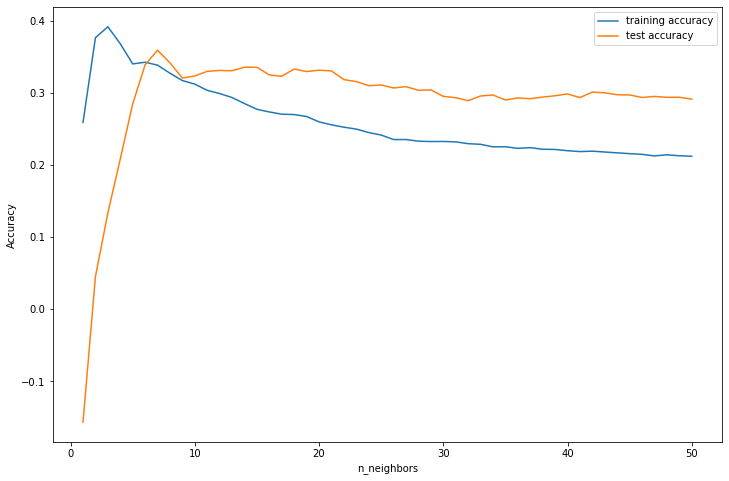

The optimal number of neighbors is 7


In [650]:
# creating lists for training set accuracy and test set accuracy
training_accuracy = []
test_accuracy     = []


# building a visualization of 1 to 50 neighbors
neighbors_settings = range(1, 51)


for n_neighbors in neighbors_settings:
    # Building the model
    clf = KNeighborsRegressor(n_neighbors = n_neighbors)
    clf.fit(x_train, y_train)
    
    # Recording the training set accuracy
    training_accuracy.append(clf.score(x_train, y_train))
    
    # Recording the generalization accuracy
    test_accuracy.append(clf.score(x_test, y_test))


# plotting the visualization
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.show()

# finding the optimal number of neighbors
opt_neighbors = test_accuracy.index(max(test_accuracy)) + 1
print(f"""The optimal number of neighbors is {opt_neighbors}""")

In [662]:
# building model with k = 8
# above it says the optimal number is 7 but after testing multiple times I found that 8 gave the highest AUC
GOTC_knn = KNeighborsClassifier(n_neighbors = 8)

# fitting the model based on the training data
GOTC_knn_fit = GOTC_knn.fit(x_train, y_train)

# scoring the model
GOTC_knn_score = GOTC_knn.score(x_test, y_test)

# generating predictions based on the optimal KNN model
GOTC_knn_optimal_pred = GOTC_knn_fit.predict(x_test)

print('Training Score:', GOTC_knn_fit.score(x_train, y_train).round(4))
print('Testing Score:', GOTC_knn_fit.score(x_test, y_test).round(4))

knn_test = GOTC_knn_fit.score(x_test, y_test).round(4)
knn_train = GOTC_knn_fit.score(x_train, y_train).round(4)

# generating predictions
GOTC_knn_pred = GOTC_knn_fit.predict(x_test)

GOTC_knn_pred_probabilities = GOTC_knn_fit.predict_proba(x_test)
# saving AUC score
GOTC_knn_auc_score   = roc_auc_score(y_true  = y_test,
                                y_score = GOTC_knn_optimal_pred).round(4)
print('KNN AUC Score:', GOTC_knn_auc_score)


Training Score: 0.8155
Testing Score: 0.841
KNN AUC Score: 0.7817


In [654]:
# unpacking the confusion matrix
knn_tree_tn, \
knn_tree_fp, \
knn_tree_fn, \
knn_tree_tp = confusion_matrix(y_true = y_test, y_pred = GOTC_knn_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {knn_tree_tn}
False Positives: {knn_tree_fp}
False Negatives: {knn_tree_fn}
True Positives : {knn_tree_tp}
""")


True Negatives : 33
False Positives: 17
False Negatives: 14
True Positives : 131



In [655]:
# INSTANTIATING a classification tree object
full_tree = DecisionTreeClassifier()


# FITTING the training data
full_tree_fit = full_tree.fit(x_train, y_train)


# PREDICTING on new data
full_tree_pred = full_tree_fit.predict(x_test)


# SCORING the model
print('Full Tree Training ACCURACY:', full_tree_fit.score(x_train,
                                                     y_train).round(4))

print('Full Tree Testing ACCURACY :', full_tree_fit.score(x_test,
                                                     y_test).round(4))

print('Full Tree AUC Score:', roc_auc_score(y_true  = y_test,
                                            y_score = full_tree_pred).round(4))


# saving scoring data for future use
full_tree_train_score = full_tree_fit.score(x_train, y_train).round(4) # accuracy
full_tree_test_score  = full_tree_fit.score(x_test, y_test).round(4)   # accuracy


# saving AUC
full_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                      y_score = full_tree_pred).round(4) # auc

Full Tree Training ACCURACY: 0.8806
Full Tree Testing ACCURACY : 0.7897
Full Tree AUC Score: 0.7407


In [656]:
# unpacking the confusion matrix
full_tree_tn, \
full_tree_fp, \
full_tree_fn, \
full_tree_tp = confusion_matrix(y_true = y_test, y_pred = full_tree_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {full_tree_tn}
False Positives: {full_tree_fp}
False Negatives: {full_tree_fn}
True Positives : {full_tree_tp}
""")


True Negatives : 32
False Positives: 18
False Negatives: 23
True Positives : 122



In [657]:
# INSTANTIATING a classification tree object
tree_pruned = DecisionTreeClassifier(max_depth = 2,
                                     min_samples_leaf = 25,
                                     random_state = 219)


# FITTING the training data
tree_pruned_fit = tree_pruned.fit(x_train, y_train)


# PREDICTING on new data
tree_pruned_pred = tree_pruned_fit.predict(x_test)


# SCORING the model
print('Training ACCURACY:', tree_pruned_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', tree_pruned_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tree_pruned_pred).round(4))


# saving scoring data for future use
tree_pruned_train_score = tree_pruned_fit.score(x_train, y_train).round(4) # accuracy
tree_pruned_test_score  = tree_pruned_fit.score(x_test, y_test).round(4) # accuracy


# saving auc score
tree_pruned_auc_score   = roc_auc_score(y_true  = y_test,
                                        y_score = tree_pruned_pred).round(4) # auc

Training ACCURACY: 0.7744
Testing  ACCURACY: 0.8462
AUC Score        : 0.7721


In [658]:
# unpacking the confusion matrix
pruned_tree_tn, \
pruned_tree_fp, \
pruned_tree_fn, \
pruned_tree_tp = confusion_matrix(y_true = y_test, y_pred = tree_pruned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {pruned_tree_tn}
False Positives: {pruned_tree_fp}
False Negatives: {pruned_tree_fn}
True Positives : {pruned_tree_tp}
""")


True Negatives : 31
False Positives: 19
False Negatives: 11
True Positives : 134



In [668]:
# comparing results
print(f"""
Model         AUC Score      TN, FP, FN, TP
-----         ---------      --------------
Logistic      {logreg_auc_score}         {logreg_tn, logreg_fp, logreg_fn, logreg_tp}
Full Tree     {full_tree_auc_score}         {full_tree_tn, full_tree_fp, full_tree_fn, full_tree_tp}
Pruned Tree   {tree_pruned_auc_score}         {pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp}
KNN Optimal   {GOTC_knn_auc_score}         {knn_tree_tn, knn_tree_fp, knn_tree_fn, knn_tree_tp}
""")


# creating a dictionary for model results
model_performance = {
    
    'Model Name'    : ['Logistic', 'Full Tree', 'Pruned Tree', 'KNN'],
           
    'AUC Score' : [logreg_auc_score, full_tree_auc_score, tree_pruned_auc_score, GOTC_knn_auc_score],
    
    'Training Accuracy' : [logreg_train_score, full_tree_train_score,
                           tree_pruned_train_score, GOTC_knn_fit.score(x_train, y_train).round(4)],
           
    'Testing Accuracy'  : [logreg_test_score, full_tree_test_score,
                           tree_pruned_test_score, GOTC_knn_fit.score(x_test, y_test).round(4)],

    'Confusion Matrix'  : [(logreg_tn, logreg_fp, logreg_fn, logreg_tp),
                           (full_tree_tn, full_tree_fp, full_tree_fn, full_tree_tp),
                           (pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp),
                           (knn_tree_tn, knn_tree_fp, knn_tree_fn, knn_tree_tp)]}


# converting model_performance into a DataFrame
model_performance = pd.DataFrame(model_performance)




Model         AUC Score      TN, FP, FN, TP
-----         ---------      --------------
Logistic      0.7231         (23, 27, 2, 143)
Full Tree     0.7407         (32, 18, 23, 122)
Pruned Tree   0.7721         (31, 19, 11, 134)
KNN Optimal   0.7817         (33, 17, 14, 131)



In [669]:
# train/test split with the logit_sig variables
GOTC_data   =  GOTC_data_small
GOTC_target =  GOTC.loc[ : , 'isAlive']


# train/test split
x_train, x_test, y_train, y_test = train_test_split(
            GOTC_data,
            GOTC_target,
            random_state = 219,
            test_size    = 0.10,
            stratify     = GOTC_target)

In [670]:
# INSTANTIATING a random forest model with default values
rf_default = RandomForestClassifier(n_estimators     = 100,
                                    criterion        = 'gini',
                                    max_depth        = None,
                                    min_samples_leaf = 1,
                                    bootstrap        = True,
                                    warm_start       = False,
                                    random_state     = 219)

In [671]:
# FITTING the training data
rf_default_fit = rf_default.fit(x_train, y_train)


# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', rf_default_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', rf_default_fit.score(x_test, y_test).round(4))


# saving AUC score
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = rf_default_fit_pred).round(4))

Training ACCURACY: 0.8806
Testing  ACCURACY: 0.8256
AUC Score        : 0.7583


In [672]:
# unpacking the confusion matrix
rf_tn, \
rf_fp, \
rf_fn, \
rf_tp = confusion_matrix(y_true = y_test, y_pred = rf_default_fit_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {rf_tn}
False Positives: {rf_fp}
False Negatives: {rf_fn}
True Positives : {rf_tp}
""")


True Negatives : 31
False Positives: 19
False Negatives: 15
True Positives : 130



In [673]:
# declaring model performance objects
rf_train_acc = rf_default_fit.score(x_train, y_train).round(4)
rf_test_acc  = rf_default_fit.score(x_test, y_test).round(4)
rf_auc       = roc_auc_score(y_true  = y_test,
                             y_score = rf_default_fit_pred).round(4)


# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'         : 'Random Forest (Full)',
                           'Training Accuracy'  : rf_train_acc,
                           'Testing Accuracy'   : rf_test_acc,
                           'AUC Score'          : rf_auc,
                           'Confusion Matrix'   : (rf_tn,
                                                   rf_fp,
                                                   rf_fn,
                                                   rf_tp)},
                          ignore_index = True)


# checking the results
model_performance

,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,Logistic,0.7231,0.7813,0.8513,"(23, 27, 2, 143)"
1,Full Tree,0.7407,0.8806,0.7897,"(32, 18, 23, 122)"
2,Pruned Tree,0.7721,0.7744,0.8462,"(31, 19, 11, 134)"
3,KNN,0.7817,0.8155,0.8410,"(33, 17, 14, 131)"
4,Random Forest (Full),0.7583,0.8806,0.8256,"(31, 19, 15, 130)"


In [ ]:
# FITTING the training data
rf_default_fit = rf_default.fit(x_train, y_train)


# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(x_test)


# declaring a hyperparameter space
estimator_range  = np.arange(50, 1100, 50)
leaf_range       = np.arange(1, 51, 5)
depth_range      = np.arange(2, 8, 1)
criterion_range  = ['gini', 'entropy']
bootstrap_range  = [True, False]
warm_start_range = [True, False]


# creating a hyperparameter grid
param_grid = {'n_estimators'     : estimator_range,
              'min_samples_leaf' : leaf_range,
              'max_depth'        : depth_range,
              'criterion'        : criterion_range,
              'bootstrap'        : bootstrap_range,
              'warm_start'       : warm_start_range}


# INSTANTIATING the model object without hyperparameters
forest_grid = RandomForestClassifier(random_state = 219)


# GridSearchCV object
forest_cv = RandomizedSearchCV(estimator           = forest_grid,
                               param_distributions = param_grid,
                               cv         = 3,
                               n_iter     = 1000,
                               scoring    = make_scorer(roc_auc_score,
                                            needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
forest_cv.fit(GOTC_data, GOTC_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
print("Tuned Parameters  :", forest_cv.best_params_)
print("Tuned Training AUC:", forest_cv.best_score_.round(4))

In [674]:
# best estimators based on RandomizedSearchCV
forest_cv.best_estimator_

RandomForestClassifier(max_depth=7, n_estimators=950, random_state=219)

In [675]:
# INSTANTIATING a random forest model with optimized hyperparameter values
rf_tuned = RandomForestClassifier(n_estimators     = 950,
                                    criterion        = 'gini',
                                    max_depth        = 7,
                                    min_samples_leaf = 1,
                                    bootstrap        = True,
                                    warm_start       = False,
                                    random_state     = 219)

In [676]:
# FITTING the training data
rf_tuned_fit = rf_tuned.fit(x_train, y_train)


# PREDICTING based on the testing set
rf_tuned_fit_pred = rf_tuned_fit.predict(x_test)


# SCORING the results
print('RF Tuned Training ACCURACY:', rf_tuned_fit.score(x_train, y_train).round(4))
print('RF Tuned Testing  ACCURACY:', rf_tuned_fit.score(x_test, y_test).round(4))


# saving AUC score
print('RF Tuned AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = rf_tuned_fit_pred).round(4))

RF Tuned Training ACCURACY: 0.827
RF Tuned Testing  ACCURACY: 0.8462
RF Tuned AUC Score        : 0.7459


In [677]:
# unpacking the confusion matrix
rf_tuned_tn, \
rf_tuned_fp, \
rf_tuned_fn, \
rf_tuned_tp = confusion_matrix(y_true = y_test, y_pred = rf_tuned_fit_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {rf_tuned_tn}
False Positives: {rf_tuned_fp}
False Negatives: {rf_tuned_fn}
True Positives : {rf_tuned_tp}
""")


True Negatives : 27
False Positives: 23
False Negatives: 7
True Positives : 138



In [678]:
# declaring model performance objects
rf_tuned_train_acc = rf_tuned_fit.score(x_train, y_train).round(4)
rf_tuned_test_acc  = rf_tuned_fit.score(x_test, y_test).round(4)
rf_tuned_auc       = roc_auc_score(y_true  = y_test,
                             y_score = rf_tuned_fit_pred).round(4)


# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'         : 'Random Forest (Tuned)',
                           'Training Accuracy'  : rf_tuned_train_acc,
                           'Testing Accuracy'   : rf_tuned_test_acc,
                           'AUC Score'          : rf_tuned_auc,
                           'Confusion Matrix'   : (rf_tuned_tn,
                                                   rf_tuned_fp,
                                                   rf_tuned_fn,
                                                   rf_tuned_tp)},
                          ignore_index = True)


# checking the results
model_performance

,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,Logistic,0.7231,0.7813,0.8513,"(23, 27, 2, 143)"
1,Full Tree,0.7407,0.8806,0.7897,"(32, 18, 23, 122)"
2,Pruned Tree,0.7721,0.7744,0.8462,"(31, 19, 11, 134)"
3,KNN,0.7817,0.8155,0.8410,"(33, 17, 14, 131)"
4,Random Forest (Full),0.7583,0.8806,0.8256,"(31, 19, 15, 130)"
5,Random Forest (Tuned),0.7459,0.8270,0.8462,"(27, 23, 7, 138)"


In [679]:
# INSTANTIATING the model object without hyperparameters
full_gbm_default = GradientBoostingClassifier(loss          = 'deviance',
                                              learning_rate = 0.1,
                                              n_estimators  = 100,
                                              criterion     = 'friedman_mse',
                                              max_depth     = 3,
                                              warm_start    = False,
                                              random_state  = 219)


# FIT step is needed as we are not using .best_estimator
full_gbm_default_fit = full_gbm_default.fit(x_train, y_train)


# PREDICTING based on the testing set
full_gbm_default_pred = full_gbm_default_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', full_gbm_default_fit.score(x_train, y_train).round(4))
print('Testing ACCURACY :', full_gbm_default_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = full_gbm_default_pred).round(4))

Training ACCURACY: 0.8287
Testing ACCURACY : 0.8564
AUC Score        : 0.7528


In [680]:
# unpacking the confusion matrix
full_gbm_tn, \
full_gbm_fp, \
full_gbm_fn, \
full_gbm_tp = confusion_matrix(y_true = y_test, y_pred = full_gbm_default_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {full_gbm_tn}
False Positives: {full_gbm_fp}
False Negatives: {full_gbm_fn}
True Positives : {full_gbm_tp}
""")


True Negatives : 27
False Positives: 23
False Negatives: 5
True Positives : 140



In [681]:
# declaring model performance objects
full_gbm_train_acc = full_gbm_default_fit.score(x_train, y_train).round(4)
full_gbm_test_acc  = full_gbm_default_fit.score(x_test, y_test).round(4)
full_gbm_auc       = roc_auc_score(y_true  = y_test,
                             y_score = full_gbm_default_pred).round(4)


# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'         : 'Full GBM',
                           'Training Accuracy'  : full_gbm_train_acc,
                           'Testing Accuracy'   : full_gbm_test_acc,
                           'AUC Score'          : full_gbm_auc,
                           'Confusion Matrix'   : (full_gbm_tn,
                                                   full_gbm_fp,
                                                   full_gbm_fn,
                                                   full_gbm_tp)},
                          ignore_index = True)


# checking the results
model_performance

,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,Logistic,0.7231,0.7813,0.8513,"(23, 27, 2, 143)"
1,Full Tree,0.7407,0.8806,0.7897,"(32, 18, 23, 122)"
2,Pruned Tree,0.7721,0.7744,0.8462,"(31, 19, 11, 134)"
3,KNN,0.7817,0.8155,0.8410,"(33, 17, 14, 131)"
4,Random Forest (Full),0.7583,0.8806,0.8256,"(31, 19, 15, 130)"
5,Random Forest (Tuned),0.7459,0.8270,0.8462,"(27, 23, 7, 138)"
6,Full GBM,0.7528,0.8287,0.8564,"(27, 23, 5, 140)"


In [682]:
# INSTANTIATING the model object without hyperparameters
full_gbm_tuned = GradientBoostingClassifier(loss          = 'deviance',
                                              learning_rate = 1.3000000000000003,
                                              n_estimators  = 350,
                                              criterion     = 'friedman_mse',
                                              max_depth     = 6,
                                              warm_start    = True,
                                              random_state  = 219)


# FIT step is needed as we are not using .best_estimator
full_gbm_tuned_fit = full_gbm_tuned.fit(x_train, y_train)


# PREDICTING based on the testing set
full_gbm_tuned_pred = full_gbm_tuned_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', full_gbm_tuned_fit.score(x_train, y_train).round(4))
print('Testing ACCURACY :', full_gbm_tuned_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = full_gbm_tuned_pred).round(4))

Training ACCURACY: 0.8766
Testing ACCURACY : 0.8308
AUC Score        : 0.7748


In [683]:
# unpacking the confusion matrix
tuned_gbm_tn, \
tuned_gbm_fp, \
tuned_gbm_fn, \
tuned_gbm_tp = confusion_matrix(y_true = y_test, y_pred = full_gbm_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {tuned_gbm_tn}
False Positives: {tuned_gbm_fp}
False Negatives: {tuned_gbm_fn}
True Positives : {tuned_gbm_tp}
""")


True Negatives : 33
False Positives: 17
False Negatives: 16
True Positives : 129



In [684]:
# declaring model performance objects
tuned_gbm_train_acc = full_gbm_tuned_fit.score(x_train, y_train).round(4)
tuned_gbm_test_acc  = full_gbm_tuned_fit.score(x_test, y_test).round(4)
tuned_gbm_auc       = roc_auc_score(y_true  = y_test,
                             y_score = full_gbm_tuned_pred).round(4)


# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'         : 'Tuned GBM',
                           'Training Accuracy'  : tuned_gbm_train_acc,
                           'Testing Accuracy'   : tuned_gbm_test_acc,
                           'AUC Score'          : tuned_gbm_auc,
                           'Confusion Matrix'   : (tuned_gbm_tn,
                                                   tuned_gbm_fp,
                                                   tuned_gbm_fn,
                                                   tuned_gbm_tp)},
                          ignore_index = True)


# checking the results
print(model_performance)


              Model Name  AUC Score  Training Accuracy  Testing Accuracy   Confusion Matrix
0               Logistic     0.7231             0.7813            0.8513   (23, 27, 2, 143)
1              Full Tree     0.7407             0.8806            0.7897  (32, 18, 23, 122)
2            Pruned Tree     0.7721             0.7744            0.8462  (31, 19, 11, 134)
3                    KNN     0.7817             0.8155            0.8410  (33, 17, 14, 131)
4   Random Forest (Full)     0.7583             0.8806            0.8256  (31, 19, 15, 130)
5  Random Forest (Tuned)     0.7459             0.8270            0.8462   (27, 23, 7, 138)
6               Full GBM     0.7528             0.8287            0.8564   (27, 23, 5, 140)
7              Tuned GBM     0.7748             0.8766            0.8308  (33, 17, 16, 129)


In [ ]:
# declaring a hyperparameter space
learn_range        = np.arange(0.1, 3.2, 0.1)
estimator_range    = np.arange(100, 901, 25)
depth_range        = np.arange(2, 8, 2)
warm_start_range   = [True, False]

# creating a hyperparameter grid
param_grid = {'learning_rate' : learn_range,
              'max_depth'     : depth_range,
              'n_estimators'  : estimator_range,
              'warm_start'    : warm_start_range}


# INSTANTIATING the model object without hyperparameters
full_gbm_grid = GradientBoostingClassifier(random_state = 219)


# GridSearchCV object
full_gbm_cv = RandomizedSearchCV(estimator     = full_gbm_grid,
                           param_distributions = param_grid,
                           cv                  = 3,
                           n_iter              = 500,
                           random_state        = 219,
                           scoring             = make_scorer(roc_auc_score,
                                                 needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
full_gbm_cv.fit(GOTC_data, GOTC_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
print("Tuned Parameters  :", full_gbm_cv.best_params_)
print("Tuned Training AUC:", full_gbm_cv.best_score_.round(4))

In [685]:
print(f"""The best model was:        Model Name         : KNN Optimized
                           Training Accuracy  : {knn_train}
                           Testing Accuracy   : {knn_test}
                           AUC Score          : {GOTC_knn_auc_score} 
                           Confusion Matrix   : True Negatives : {knn_tree_tn}
                                                False Positives: {knn_tree_fp}
                                                False Negatives: {knn_tree_fn}
                                                True Positives : {knn_tree_tp}""")

The best model was:        Model Name         : KNN Optimized
                           Training Accuracy  : 0.8155
                           Testing Accuracy   : 0.841
                           AUC Score          : 0.7817 
                           Confusion Matrix   : True Negatives : 33
                                                False Positives: 17
                                                False Negatives: 14
                                                True Positives : 131
